In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from glob import glob

# --- Parámetros de detección de picos ---
UMBRAL_ALTURA_RELATIVA = 0.1
PROMINENCE_MINIMA = 0.05
DISTANCIA_MINIMA_PUNTOS = 5
NUM_MAX_HARMONICOS = 5  # Número máximo de armónicos a mostrar

def cargar_datos(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data_lines = [line for line in lines if not line.startswith('#')]
    temp_path = 'temp_data.tsv'
    with open(temp_path, 'w', encoding='utf-8') as f:
        f.writelines(data_lines)
    df = pd.read_csv(temp_path, sep='\t', engine='python')
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    return df

def calcular_frecuencia_muestreo(tiempos):
    if len(tiempos) > 1:
        frecuencia = 1 / np.mean(np.diff(tiempos))
        print(f"Frecuencia de muestreo estimada: {frecuencia:.2f} Hz")
        return frecuencia
    else:
        print("No hay suficientes puntos de tiempo para estimar la frecuencia de muestreo.")
        return None

def aplicar_fft(senal, frecuencia_muestreo):
    N = len(senal)
    transformada = np.fft.fft(senal)
    amplitudes = np.abs(transformada)
    frecuencias = np.fft.fftfreq(N, d=1/frecuencia_muestreo)
    return frecuencias, amplitudes, N

def graficar_resultados(tiempo, angulos, espectros, nombre_archivo, output_dir):
    nombres = ['1', '2', '3']
    colores = ['skyblue', 'magenta', 'purple']
    plt.figure(figsize=(12, 6))

    # Ángulo vs Tiempo
    plt.subplot(2, 1, 1)
    for i, angulo in enumerate(angulos):
        plt.plot(tiempo, angulo, label=f'Péndulo {nombres[i]}', color=colores[i])
    plt.title('Ángulo vs Tiempo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Ángulo (rad)')
    plt.legend()
    plt.grid(True)

    # Espectro de frecuencias
    plt.subplot(2, 1, 2)
    for i, (frec, amp, N) in enumerate(espectros):
        frec_pos = frec > 0
        frec_plot = frec[frec_pos]
        amp_plot = amp[frec_pos] * 2 / N

        plt.plot(frec_plot, amp_plot, label=f'Péndulo {nombres[i]}', color=colores[i])

        # Detección de picos (solo el más alto)
        peaks, properties = find_peaks(
            amp_plot,
            height=np.max(amp_plot) * UMBRAL_ALTURA_RELATIVA,
            prominence=PROMINENCE_MINIMA,
            distance=DISTANCIA_MINIMA_PUNTOS
        )

        print(f"\n🎯 Frecuencia más destacada para Péndulo {nombres[i]}:")
        if len(peaks) > 0:
            alturas = properties['peak_heights']
            idx_max = np.argmax(alturas)
            p = peaks[idx_max]

            freq_val = frec_plot[p]
            amp_val = amp_plot[p]
            print(f" - {freq_val:.2f} Hz (amplitud: {amp_val:.4f})")

            # Marca el pico principal
            plt.plot(freq_val, amp_val, 'o', color=colores[i])
            plt.text(freq_val, amp_val, f'{freq_val:.2f} Hz', fontsize=8,
                     ha='left', va='bottom', rotation=45)

            # Dibujar líneas verticales de los armónicos
            f_max = frec_plot.max()
            for n in range(2, NUM_MAX_HARMONICOS + 1):
                armonico = n * freq_val
                if armonico < f_max:
                    plt.axvline(armonico, color=colores[i], linestyle='--', alpha=0.5)
                    plt.text(armonico, plt.ylim()[1]*0.9, f'{n}ω', color=colores[i],
                             rotation=90, va='top', ha='center', fontsize=8)
        else:
            print(" - No se detectaron picos significativos.")

    plt.title('Espectro de Frecuencias')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(nombre_archivo))[0]
    output_file = os.path.join(output_dir, f"{base_name}.pdf")
    plt.savefig(output_file, format='pdf', dpi=300)
    print(f"\n📁 Gráfico guardado como: {output_file}")
    plt.close()

# ---- PROCESAMIENTO DE TODOS LOS ARCHIVOS ----

archivos_tsv = glob("*.tsv")
output_dir = "figures"

for archivo in archivos_tsv:
    print(f"\n📄 Procesando archivo: {archivo}")
    try:
        df = cargar_datos(archivo)

        if df.shape[1] < 4:
            print("⚠️  El archivo debe contener al menos 4 columnas: tiempo + 3 ángulos.")
            continue

        tiempos = df.iloc[:, 0].values
        angulos = [df.iloc[:, i].values for i in range(1, 4)]

        duracion_maxima = 30
        indices_validos = tiempos <= duracion_maxima
        tiempos = tiempos[indices_validos]
        angulos = [a[indices_validos] for a in angulos]

        frecuencia = calcular_frecuencia_muestreo(tiempos)

        if frecuencia:
            espectros = [aplicar_fft(angulo, frecuencia) for angulo in angulos]
            graficar_resultados(tiempos, angulos, espectros, archivo, output_dir)
        else:
            print("FFT no realizada por falta de frecuencia de muestreo.")
    except Exception as e:
        print(f"❌ Error procesando el archivo {archivo}: {e}")



📄 Procesando archivo: 010_26_filtrado.tsv
Frecuencia de muestreo estimada: 18.24 Hz

🎯 Frecuencia más destacada para Péndulo 1:
 - 0.84 Hz (amplitud: 2.9353)

🎯 Frecuencia más destacada para Péndulo 2:
 - 0.84 Hz (amplitud: 7.7784)

🎯 Frecuencia más destacada para Péndulo 3:
 - 1.21 Hz (amplitud: 0.6838)

📁 Gráfico guardado como: figures/010_26_filtrado.pdf

📄 Procesando archivo: 010_15_filtrado.tsv
Frecuencia de muestreo estimada: 18.60 Hz

🎯 Frecuencia más destacada para Péndulo 1:
 - 0.83 Hz (amplitud: 2.6399)

🎯 Frecuencia más destacada para Péndulo 2:
 - 0.83 Hz (amplitud: 9.3439)

🎯 Frecuencia más destacada para Péndulo 3:
 - 0.83 Hz (amplitud: 0.2315)

📁 Gráfico guardado como: figures/010_15_filtrado.pdf

📄 Procesando archivo: 001_66_filtrado.tsv
Frecuencia de muestreo estimada: 18.24 Hz

🎯 Frecuencia más destacada para Péndulo 1:
 - 1.31 Hz (amplitud: 7.8405)

🎯 Frecuencia más destacada para Péndulo 2:
 - 0.87 Hz (amplitud: 0.5589)

🎯 Frecuencia más destacada para Péndulo 3:
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from glob import glob

# --- Parámetros ---
UMBRAL_ALTURA_RELATIVA = 0.1
PROMINENCE_MINIMA = 0.05
DISTANCIA_MINIMA_PUNTOS = 5
NUM_MAX_HARMONICOS = 5

def cargar_datos(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data_lines = [line for line in lines if not line.startswith('#')]
    temp_path = 'temp_data.tsv'
    with open(temp_path, 'w', encoding='utf-8') as f:
        f.writelines(data_lines)
    df = pd.read_csv(temp_path, sep='\t', engine='python')
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    return df

def calcular_frecuencia_muestreo(tiempos):
    if len(tiempos) > 1:
        frecuencia = 1 / np.mean(np.diff(tiempos))
        print(f"Frecuencia de muestreo estimada: {frecuencia:.2f} Hz")
        return frecuencia
    else:
        print("No hay suficientes puntos de tiempo para estimar la frecuencia de muestreo.")
        return None

def aplicar_fft(senal, frecuencia_muestreo):
    N = len(senal)
    transformada = np.fft.fft(senal)
    amplitudes = np.abs(transformada)
    frecuencias = np.fft.fftfreq(N, d=1/frecuencia_muestreo)
    return frecuencias, amplitudes, N

def graficar_resultados(tiempo, angulos, espectros, nombre_archivo, armonicos_usuario, output_dir):
    nombres = ['1', '2', '3']
    colores = ['limegreen', 'magenta', 'purple']
    plt.figure(figsize=(12, 6))

    # Ángulo vs Tiempo
    plt.subplot(2, 1, 1)
    for i, angulo in enumerate(angulos):
        plt.plot(tiempo, angulo, label=f'Péndulo {nombres[i]}', color=colores[i])
    plt.title('Ángulo vs Tiempo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Ángulo (rad)')
    plt.legend()
    plt.grid(True)

    # Espectro de frecuencias
    plt.subplot(2, 1, 2)
    for i, (frec, amp, N) in enumerate(espectros):
        frec_pos = frec > 0
        frec_plot = frec[frec_pos]
        amp_plot = amp[frec_pos] * 2 / N

        plt.plot(frec_plot, amp_plot, label=f'Péndulo {nombres[i]}', color=colores[i])

        peaks, properties = find_peaks(
            amp_plot,
            height=np.max(amp_plot) * UMBRAL_ALTURA_RELATIVA,
            prominence=PROMINENCE_MINIMA,
            distance=DISTANCIA_MINIMA_PUNTOS
        )

        print(f"\n🎯 Péndulo {nombres[i]}")
        if len(peaks) > 0:
            alturas = properties['peak_heights']
            idx_max = np.argmax(alturas)
            p = peaks[idx_max]

            freq_val = frec_plot[p]
            amp_val = amp_plot[p]
            print(f" - Pico más alto: {freq_val:.2f} Hz (amplitud: {amp_val:.4f})")

            plt.plot(freq_val, amp_val, 'o', color=colores[i])
            plt.text(freq_val, amp_val, f'{freq_val:.2f} Hz', fontsize=8,
                     ha='left', va='bottom', rotation=45)

            # 🧠 Usa el armónico que tú le diste
            arm_usuario = armonicos_usuario[i]
            f_base = freq_val / arm_usuario
            print(f"   Frecuencia base estimada: f₀ = {freq_val:.2f} / {arm_usuario} = {f_base:.2f} Hz")

            # 🔢 Líneas verticales en múltiplos de f₀
            f_max = frec_plot.max()
            for n in range(1, NUM_MAX_HARMONICOS + 1):
                armonico = n * f_base
                if armonico < f_max:
                    plt.axvline(armonico, color=colores[i], linestyle='--', alpha=0.5)
                    plt.text(armonico, plt.ylim()[1]*0.9, f'{n}×ω₀', color=colores[i],
                             rotation=90, va='top', ha='center', fontsize=8)

            # ✅ Mostrar f₀ en la parte inferior derecha
            plt.text(0.95, 0.05 + 0.05 * i,
                     f'f₀ (Péndulo {nombres[i]}): {f_base:.2f} Hz',
                     transform=plt.gca().transAxes,
                     fontsize=9, color=colores[i],
                     ha='right', va='bottom')

        else:
            print(" - No se detectaron picos significativos.")

    plt.title('Espectro de Frecuencias')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(nombre_archivo))[0]
    output_file = os.path.join(output_dir, f"{base_name}.pdf")
    plt.savefig(output_file, format='pdf', dpi=300)
    print(f"\n📁 Gráfico guardado como: {output_file}")
    plt.close()

# === BUCLE DE ARCHIVOS ===
archivos = sorted(glob("*_filtrado.tsv"))
output_dir = "figures"

for archivo in archivos:
    print(f"\n📄 Procesando archivo: {archivo}")

    try:
        df = cargar_datos(archivo)

        if df.shape[1] < 4:
            print("⚠️  El archivo debe tener al menos 4 columnas.")
            continue

        tiempos = df.iloc[:, 0].values
        angulos = [df.iloc[:, i].values for i in range(1, 4)]

        duracion_maxima = 30
        indices_validos = tiempos <= duracion_maxima
        tiempos = tiempos[indices_validos]
        angulos = [a[indices_validos] for a in angulos]

        frecuencia = calcular_frecuencia_muestreo(tiempos)
        if not frecuencia:
            continue

        espectros = [aplicar_fft(angulo, frecuencia) for angulo in angulos]

        # === Entrada manual de armónicos ===
        armonicos_usuario = []
        for i in range(3):
            while True:
                try:
                    n = int(input(f"🧭 ¿En qué armónico está el pico principal del péndulo {i+1}? (Ej: 1, 2, 3): "))
                    if n >= 1:
                        armonicos_usuario.append(n)
                        break
                    else:
                        print("Debe ser un número entero positivo.")
                except ValueError:
                    print("Entrada inválida. Ingresa un número entero.")

        graficar_resultados(tiempos, angulos, espectros, archivo, armonicos_usuario, output_dir)

    except Exception as e:
        print(f"❌ Error procesando el archivo {archivo}: {e}")



📄 Procesando archivo: 001_16_filtrado.tsv
Frecuencia de muestreo estimada: 18.35 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  3
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  2



🎯 Péndulo 1
 - Pico más alto: 1.31 Hz (amplitud: 7.0792)
   Frecuencia base estimada: f₀ = 1.31 / 3 = 0.44 Hz

🎯 Péndulo 2
 - Pico más alto: 0.84 Hz (amplitud: 0.6308)
   Frecuencia base estimada: f₀ = 0.84 / 2 = 0.42 Hz

🎯 Péndulo 3
 - Pico más alto: 1.20 Hz (amplitud: 1.4896)
   Frecuencia base estimada: f₀ = 1.20 / 2 = 0.60 Hz

📁 Gráfico guardado como: figures/001_16_filtrado.pdf

📄 Procesando archivo: 001_66_filtrado.tsv
Frecuencia de muestreo estimada: 18.24 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  3
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  3



🎯 Péndulo 1
 - Pico más alto: 1.31 Hz (amplitud: 7.8405)
   Frecuencia base estimada: f₀ = 1.31 / 3 = 0.44 Hz

🎯 Péndulo 2
 - Pico más alto: 0.87 Hz (amplitud: 0.5589)
   Frecuencia base estimada: f₀ = 0.87 / 2 = 0.44 Hz

🎯 Péndulo 3
 - Pico más alto: 1.34 Hz (amplitud: 1.9627)
   Frecuencia base estimada: f₀ = 1.34 / 3 = 0.45 Hz

📁 Gráfico guardado como: figures/001_66_filtrado.pdf

📄 Procesando archivo: 010_15_filtrado.tsv
Frecuencia de muestreo estimada: 18.60 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  2



🎯 Péndulo 1
 - Pico más alto: 0.83 Hz (amplitud: 2.6399)
   Frecuencia base estimada: f₀ = 0.83 / 2 = 0.42 Hz

🎯 Péndulo 2
 - Pico más alto: 0.83 Hz (amplitud: 9.3439)
   Frecuencia base estimada: f₀ = 0.83 / 2 = 0.42 Hz

🎯 Péndulo 3
 - Pico más alto: 0.83 Hz (amplitud: 0.2315)
   Frecuencia base estimada: f₀ = 0.83 / 2 = 0.42 Hz

📁 Gráfico guardado como: figures/010_15_filtrado.pdf

📄 Procesando archivo: 010_26_filtrado.tsv
Frecuencia de muestreo estimada: 18.24 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  2



🎯 Péndulo 1
 - Pico más alto: 0.84 Hz (amplitud: 2.9353)
   Frecuencia base estimada: f₀ = 0.84 / 2 = 0.42 Hz

🎯 Péndulo 2
 - Pico más alto: 0.84 Hz (amplitud: 7.7784)
   Frecuencia base estimada: f₀ = 0.84 / 2 = 0.42 Hz

🎯 Péndulo 3
 - Pico más alto: 1.21 Hz (amplitud: 0.6838)
   Frecuencia base estimada: f₀ = 1.21 / 2 = 0.60 Hz

📁 Gráfico guardado como: figures/010_26_filtrado.pdf

📄 Procesando archivo: 010_66_filtrado.tsv
Frecuencia de muestreo estimada: 18.15 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  2



🎯 Péndulo 1
 - Pico más alto: 0.85 Hz (amplitud: 3.5250)
   Frecuencia base estimada: f₀ = 0.85 / 2 = 0.43 Hz

🎯 Péndulo 2
 - Pico más alto: 0.85 Hz (amplitud: 9.4295)
   Frecuencia base estimada: f₀ = 0.85 / 2 = 0.43 Hz

🎯 Péndulo 3
 - Pico más alto: 0.85 Hz (amplitud: 3.5329)
   Frecuencia base estimada: f₀ = 0.85 / 2 = 0.43 Hz

📁 Gráfico guardado como: figures/010_66_filtrado.pdf

📄 Procesando archivo: 101_16_filtrado.tsv
Frecuencia de muestreo estimada: 18.16 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  3
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  3



🎯 Péndulo 1
 - Pico más alto: 1.33 Hz (amplitud: 5.9220)
   Frecuencia base estimada: f₀ = 1.33 / 3 = 0.44 Hz

🎯 Péndulo 2
 - Pico más alto: 0.85 Hz (amplitud: 1.0465)
   Frecuencia base estimada: f₀ = 0.85 / 2 = 0.43 Hz

🎯 Péndulo 3
 - Pico más alto: 1.19 Hz (amplitud: 13.8340)
   Frecuencia base estimada: f₀ = 1.19 / 3 = 0.40 Hz

📁 Gráfico guardado como: figures/101_16_filtrado.pdf

📄 Procesando archivo: 111_11_filtrado.tsv
Frecuencia de muestreo estimada: 18.20 Hz


🧭 ¿En qué armónico está el pico principal del péndulo 1? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 2? (Ej: 1, 2, 3):  2
🧭 ¿En qué armónico está el pico principal del péndulo 3? (Ej: 1, 2, 3):  2



🎯 Péndulo 1
 - Pico más alto: 1.14 Hz (amplitud: 13.6424)
   Frecuencia base estimada: f₀ = 1.14 / 2 = 0.57 Hz

🎯 Péndulo 2
 - Pico más alto: 0.79 Hz (amplitud: 9.4558)
   Frecuencia base estimada: f₀ = 0.79 / 2 = 0.39 Hz

🎯 Péndulo 3
 - Pico más alto: 1.21 Hz (amplitud: 7.7948)
   Frecuencia base estimada: f₀ = 1.21 / 2 = 0.61 Hz

📁 Gráfico guardado como: figures/111_11_filtrado.pdf


✅ Video guardado como 'pendulos_animacion.mp4'


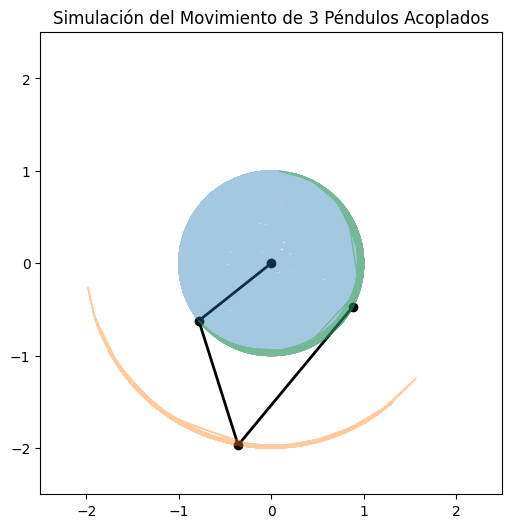

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# === CONFIGURACIÓN DEL ARCHIVO Y PARÁMETROS ===
archivo = "001_16_filtrado.tsv"  # Cambia esto por el archivo que quieras visualizar
LONGITUD_L = 1.0  # Longitud base (en metros, por ejemplo)
FPS = 30

# === CARGA Y PROCESAMIENTO DE DATOS ===
df = pd.read_csv(archivo, sep='\t', comment='#', engine='python')
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

tiempo = df.iloc[:, 0].values
angulos = [df.iloc[:, i].values for i in range(1, 4)]

# Ajustar tiempo para que sea uniforme (opcional pero recomendado para animaciones suaves)
tiempo_uniforme = np.linspace(tiempo.min(), tiempo.max(), len(tiempo))
angulos_interpolados = [np.interp(tiempo_uniforme, tiempo, a) for a in angulos]
tiempo = tiempo_uniforme

# === CÁLCULO DE POSICIONES (x, y) ===
# Pendulo 1 y 3: longitud L, Péndulo 2: longitud 2L
longitudes = [LONGITUD_L, 2 * LONGITUD_L, LONGITUD_L]

def calcular_posiciones(angulos, longitudes):
    posiciones = []
    for i in range(3):
        x = longitudes[i] * np.sin(angulos[i])
        y = -longitudes[i] * np.cos(angulos[i])
        posiciones.append((x, y))
    return posiciones

# === ANIMACIÓN ===
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
lim = 2.5 * LONGITUD_L
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('Simulación del Movimiento de 3 Péndulos Acoplados')

linea, = ax.plot([], [], 'o-', lw=2, color='black')
trazas = [ax.plot([], [], '-', lw=1, alpha=0.4)[0] for _ in range(3)]
puntos = [[], [], []]  # para guardar trayectoria

def init():
    linea.set_data([], [])
    for traza in trazas:
        traza.set_data([], [])
    return [linea] + trazas

def update(frame):
    posiciones = calcular_posiciones([a[frame] for a in angulos_interpolados], longitudes)
    x = [0] + [pos[0] for pos in posiciones]
    y = [0] + [pos[1] for pos in posiciones]
    linea.set_data(x, y)

    # Actualizar trazas
    for i in range(3):
        puntos[i].append((x[i+1], y[i+1]))
        x_data, y_data = zip(*puntos[i])
        trazas[i].set_data(x_data, y_data)

    return [linea] + trazas

ani = FuncAnimation(fig, update, frames=len(tiempo), init_func=init, blit=True, interval=1000/FPS)

# === GUARDAR LA ANIMACIÓN ===
# Opción 1: Guardar como MP4 (requiere FFmpeg)
try:
    ani.save("pendulos_animacion.mp4", fps=FPS, dpi=150)
    print("✅ Video guardado como 'pendulos_animacion.mp4'")
except Exception as e:
    print(f"⚠️ No se pudo guardar como mp4: {e}")
    # Opción 2: Guardar como GIF si falla
    ani.save("pendulos_animacion.gif", writer=PillowWriter(fps=FPS))
    print("✅ Video alternativo guardado como 'pendulos_animacion.gif'")

# Mostrar la animación (opcional si estás en Jupyter)
# plt.show()


In [ ]:
sudo 